In [1]:
import pandas as pd
import numpy as np
import pyreadr
import os

import matplotlib.pyplot as plt
import random
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
# import xgboost as xgb

import matplotlib.pyplot as plt
# import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikitplot 

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [3]:
! pip install xgboost

In [3]:
os.getcwd()

'C:\\Users\\sachin.rajendran\\Downloads\\DS\\Springboard\\DS Springboard Facilitator Toolkit-20211224T051245Z-001\\DS Springboard Facilitator Toolkit\\3. Classification Algorithms\\In Session Assignment\\Code'

In [4]:
os.chdir("..")
os.getcwd()

'C:\\Users\\sachin.rajendran\\Downloads\\DS\\Springboard\\DS Springboard Facilitator Toolkit-20211224T051245Z-001\\DS Springboard Facilitator Toolkit\\3. Classification Algorithms\\In Session Assignment'

In [5]:
path = "Data/"

df = pd.read_csv(path + "wine_store_model_data.csv")
states = pd.read_csv(path + "States.csv")
df = df.drop(columns="xid")
df.head()

,app_usage,age,gender,region,tenure,state,campaign_response,number_complaints,direct_emails,direct_mails,...,in_store_spirits_dollar_sales,delivery_spirits_dollar_sales,delivery_wine_dollar_sales,delivery_beer_dollar_sales,in_store_wine_eq_volume,in_store_beer_eq_volume,in_store_spirits_eq_volume,delivery_spirits_eq_volume,delivery_wine_eq_volume,delivery_beer_eq_volume
0,0,33,F,Urban,95,53,0,25,101,27,...,2685,3120,5925,1454,10.0,30.1,10.0,63.6,41,542
1,1,57,F,Urban,93,36,0,0,84,0,...,25,400,5925,47092,10.0,30.7,95.7,52.6,259,41
2,0,38,M,Rural,108,48,0,25,141,53,...,925,2320,55233,72134,35.5,28.3,19.4,50.8,41,199
3,0,57,M,Rural,97,36,0,19,157,36,...,25,3760,5925,58872,29.0,31.1,85.6,55.0,3284,383
4,0,41,F,Urban,95,17,0,0,76,0,...,25,3280,98577,25090,54.5,38.5,10.0,60.2,104,1654


In [6]:
df.shape

(10000, 31)

In [7]:
### The following code tells us about the level of class imbalance in the dataset. While the dataset is imbalanced,
### a 22%-78% imbalance may give us acceptable results and we may not need sampling.
### Still we'll attempt our models both with and without samping.

target_df = df.campaign_response.value_counts().reset_index()
target_df['class_percentage'] = np.round(target_df.eval(f"campaign_response/{target_df.campaign_response.sum()}"), 2)
target_df

,index,campaign_response,class_percentage
0,0,7780,0.78
1,1,2220,0.22


In [8]:
### None of the features have null values.

df.isnull().any().sum()

0

,app_usage,age,gender,region,tenure,state,campaign_response,number_complaints,direct_emails,direct_mails,...,in_store_spirits_dollar_sales,delivery_spirits_dollar_sales,delivery_wine_dollar_sales,delivery_beer_dollar_sales,in_store_wine_eq_volume,in_store_beer_eq_volume,in_store_spirits_eq_volume,delivery_spirits_eq_volume,delivery_wine_eq_volume,delivery_beer_eq_volume
0,0,between_30_50,F,Urban,95,53,0,25,101,27,...,2685,3120,5925,1454,10.0,30.1,10.0,63.6,41,542
1,1,above_50,F,Urban,93,36,0,0,84,0,...,25,400,5925,47092,10.0,30.7,95.7,52.6,259,41
2,0,between_30_50,M,Rural,108,48,0,25,141,53,...,925,2320,55233,72134,35.5,28.3,19.4,50.8,41,199
3,0,above_50,M,Rural,97,36,0,19,157,36,...,25,3760,5925,58872,29.0,31.1,85.6,55.0,3284,383
4,0,between_30_50,F,Urban,95,17,0,0,76,0,...,25,3280,98577,25090,54.5,38.5,10.0,60.2,104,1654


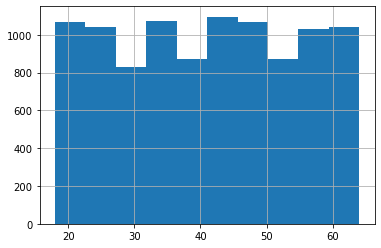

In [9]:
### Bucketting the age column for better usage of age information in the model.
### Plotting the histogram to understand the ideal bucket ranges.

df.age.hist()

bins = [0, 30, 50, 100]
df['age'] = pd.cut(df['age'], bins = bins, labels = ['below_30', 'between_30_50', 'above_50'])
df_summary = df.copy()
df.head()

In [10]:
### Checking outliers and removing them, if found

num_cols = list(df.select_dtypes([np.number]).columns)
outlier_cols = num_cols.copy()

for c in ['app_usage', 'campaign_response', 'privelege_card']:
    outlier_cols.remove(c)
df.describe()

,app_usage,tenure,state,campaign_response,number_complaints,direct_emails,direct_mails,segment,privelege_card,in_store_wine_transactions,...,in_store_spirits_dollar_sales,delivery_spirits_dollar_sales,delivery_wine_dollar_sales,delivery_beer_dollar_sales,in_store_wine_eq_volume,in_store_beer_eq_volume,in_store_spirits_eq_volume,delivery_spirits_eq_volume,delivery_wine_eq_volume,delivery_beer_eq_volume
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.449100,100.140600,38.826900,0.222000,10.553100,57.650200,16.305400,2.010700,0.296700,62.563700,...,2000.206000,2014.480000,45785.39820,20828.70280,46.255830,30.029550,46.21629,45.245860,599.785400,596.038400
std,0.497427,19.991658,29.442769,0.415612,13.126493,79.407997,20.030628,1.421474,0.456826,56.136463,...,2810.626133,1608.242872,60699.89862,29087.05422,44.137153,5.491667,44.62279,10.933439,826.848118,827.215671
min,0.000000,27.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,25.000000,80.000000,5925.00000,1454.00000,10.000000,10.000000,10.00000,4.000000,41.000000,41.000000
25%,0.000000,87.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000,...,25.000000,560.000000,5925.00000,1454.00000,10.000000,26.300000,10.00000,37.800000,41.000000,41.000000
50%,0.000000,100.000000,36.000000,0.000000,4.000000,13.000000,7.000000,2.000000,0.000000,53.000000,...,185.000000,1840.000000,5925.00000,1454.00000,28.500000,30.000000,27.70000,45.200000,41.000000,41.000000
75%,1.000000,114.000000,48.000000,0.000000,19.000000,99.000000,29.000000,3.000000,1.000000,100.000000,...,3425.000000,3120.000000,71676.00000,33906.00000,72.000000,33.800000,72.40000,52.600000,966.250000,963.250000
max,1.000000,176.000000,99.000000,1.000000,50.000000,466.000000,70.000000,4.000000,1.000000,292.000000,...,17205.000000,8720.000000,477585.00000,216610.00000,288.500000,51.000000,263.50000,95.600000,5491.000000,5432.000000


In [11]:
### For outlier removal, keeping only those data points that are within 1 and the 99th percentiles.

Q1 = df.quantile(0.01)
Q3 = df.quantile(0.99)

df = df[~((df[outlier_cols] < Q1) | (df[outlier_cols] > Q3)).any(axis=1)]
df.shape

(8088, 31)

In [12]:
### Code in this cell handles data imbalance by downsampling majority class.
### In order to see the model performance with the imbalance handled, please comment the below lines.

df_maj = df[df.campaign_response == 0]
df_min = df[df.campaign_response == 1]
 
# Downsample majority class
df_down_sampled = resample(df_maj, replace=False, n_samples=len(df_min), random_state=101)
df = df_down_sampled.append(df_min)
print(df['campaign_response'].value_counts())

0    1773
1    1773
Name: campaign_response, dtype: int64


In [13]:
### Creating dummy variables

num_cols = list(df.select_dtypes([np.number]).columns)
categorical_cols = list(set(df.columns) - set(num_cols)) + ["state", "segment"]
categorical_cols

['occupation', 'gender', 'region', 'age', 'state', 'segment']

In [14]:
num_cols.remove("campaign_response")
num_cols.remove("state")
num_cols.remove("segment")

df = pd.get_dummies(data = df, columns = categorical_cols, drop_first = True)
df

,app_usage,tenure,campaign_response,number_complaints,direct_emails,direct_mails,privelege_card,in_store_wine_transactions,in_store_beer_transactions,in_store_spirits_transactions,...,state_36,state_37,state_45,state_48,state_53,state_99,segment_1,segment_2,segment_3,segment_4
6283,0,78,0,12,176,18,0,126,66,86,...,1,0,0,0,0,0,0,1,0,0
7574,0,144,0,0,0,45,0,181,45,2,...,0,0,0,1,0,0,0,0,0,1
7227,0,104,0,13,35,0,1,146,42,22,...,0,0,0,0,0,0,0,0,0,1
4688,0,123,0,0,17,0,0,86,46,2,...,0,0,0,0,0,0,0,0,0,0
5511,0,83,0,13,0,0,0,118,60,116,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,1,73,1,39,0,0,1,152,48,5,...,0,0,0,0,0,1,0,0,0,1
9967,0,107,1,9,0,0,0,2,48,98,...,0,0,0,0,0,0,0,1,0,0
9981,0,86,1,17,0,65,0,61,40,82,...,0,0,0,1,0,0,0,0,1,0
9995,0,99,1,0,74,15,0,72,36,12,...,0,0,0,0,0,1,1,0,0,0


In [15]:
### Creating price features. Price can be determined by sales per volume.

df['in_store_wine_price'] = df.eval("in_store_wine_dollar_sales / in_store_wine_eq_volume")
df['in_store_beer_price'] = df.eval("in_store_beer_dollar_sales / in_store_beer_eq_volume")
df['in_store_spirits_price'] = df.eval("in_store_spirits_dollar_sales / in_store_spirits_eq_volume")

df['delivery_spirits_price'] = df.eval("delivery_spirits_dollar_sales / delivery_spirits_eq_volume")
df['delivery_wine_price'] = df.eval("delivery_wine_dollar_sales / delivery_wine_eq_volume")
df['delivery_beer_price'] = df.eval("delivery_beer_dollar_sales / delivery_beer_eq_volume")


### Dropping all the original columns
drop_cols_list = ["in_store_wine_dollar_sales", "in_store_wine_eq_volume", "in_store_beer_dollar_sales", 
                  "in_store_beer_eq_volume", "in_store_spirits_dollar_sales", "in_store_spirits_eq_volume",
                  "delivery_spirits_dollar_sales", "delivery_spirits_eq_volume", "delivery_wine_dollar_sales",
                  "delivery_wine_eq_volume", "delivery_beer_dollar_sales", "delivery_beer_eq_volume"]
df = df.drop(columns = drop_cols_list)

In [16]:
### Creating the train, test and validate split

df = df.sample(frac = 1, random_state = 101)

### Keeping first 60% rows for training, next 20% for validation and last 20% for testing sets.

train = df[:int(len(df)*0.6)]
validate = df[int(len(df)*0.6):int(len(df)*0.8)]
test = df[int(len(df)*0.8):]

print(train.shape)
print(validate.shape)
print(test.shape)

### Separating the target column from the three datasets in X_data and y_data format.

X_train = train.drop(columns = "campaign_response")
y_train = train["campaign_response"]

X_validate = validate.drop(columns = "campaign_response")
y_validate = validate["campaign_response"]

X_test = test.drop(columns = "campaign_response")
y_test = test["campaign_response"]

(2127, 43)
(709, 43)
(710, 43)


In [17]:
y_test.value_counts()

1    369
0    341
Name: campaign_response, dtype: int64


Training
------------------------------------------------------------
Accuracy % age: 64.6
ROC-AUC Score: 0.711

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1089
           1       0.66      0.58      0.61      1038

    accuracy                           0.65      2127
   macro avg       0.65      0.64      0.64      2127
weighted avg       0.65      0.65      0.64      2127


Confusion Matrix:
[[776 313]
 [440 598]]

 ROC-AUC Curve for the training set


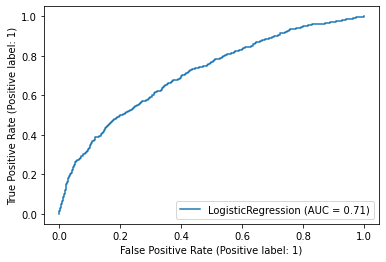

In [18]:
### Trying Logistic Regression and various error metrics
### Singular function for the error metrics. Takes actual and predicted values for the datasets and also X_data.
### Here, the probability threshold for class label assignment is kept as default 0.5.

def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"


### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_pred = log_reg.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 66.29
ROC-AUC Score: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       343
           1       0.69      0.62      0.66       366

    accuracy                           0.66       709
   macro avg       0.66      0.66      0.66       709
weighted avg       0.67      0.66      0.66       709


Confusion Matrix:
[[242 101]
 [138 228]]

 ROC-AUC Curve for the validation set


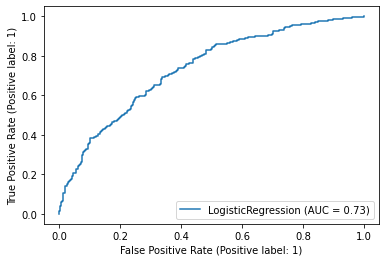

In [19]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = log_reg.predict(X_validate)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 63.94
ROC-AUC Score: 0.725

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       341
           1       0.67      0.61      0.64       369

    accuracy                           0.64       710
   macro avg       0.64      0.64      0.64       710
weighted avg       0.64      0.64      0.64       710


Confusion Matrix:
[[229 112]
 [144 225]]

 ROC-AUC Curve for the testing set


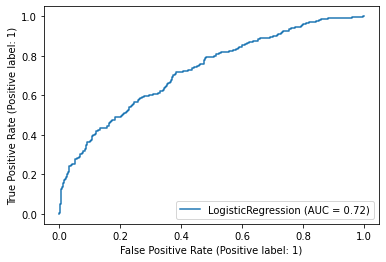

In [20]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = log_reg.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 62.62
ROC-AUC Score: 0.711

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56      1089
           1       0.59      0.79      0.67      1038

    accuracy                           0.63      2127
   macro avg       0.64      0.63      0.62      2127
weighted avg       0.64      0.63      0.62      2127


Confusion Matrix:
[[516 573]
 [222 816]]

 ROC-AUC Curve for the training set


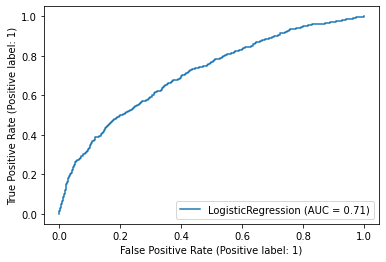

In [21]:
### Trying the same with probability thresholds as 0.4 and 0.6.

### threshold = 0.4

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train)[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.4, 1, 0)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 67.56
ROC-AUC Score: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.49      0.59       343
           1       0.64      0.85      0.73       366

    accuracy                           0.68       709
   macro avg       0.70      0.67      0.66       709
weighted avg       0.69      0.68      0.66       709


Confusion Matrix:
[[168 175]
 [ 55 311]]

 ROC-AUC Curve for the validation set


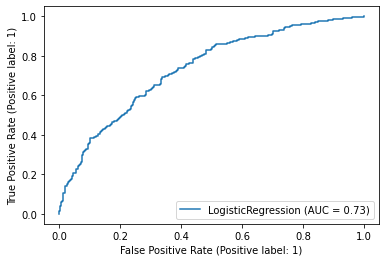

In [22]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate)[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.4, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 63.94
ROC-AUC Score: 0.725

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       341
           1       0.67      0.61      0.64       369

    accuracy                           0.64       710
   macro avg       0.64      0.64      0.64       710
weighted avg       0.64      0.64      0.64       710


Confusion Matrix:
[[229 112]
 [144 225]]

 ROC-AUC Curve for the testing set


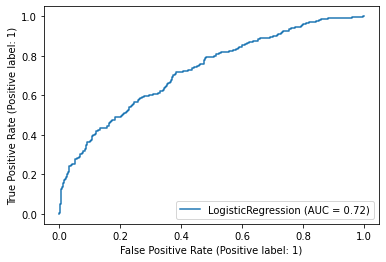

In [23]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.4, 1, 0)
y_test_pred = log_reg.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()


Training
------------------------------------------------------------
Accuracy % age: 63.66
ROC-AUC Score: 0.711

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71      1089
           1       0.74      0.40      0.52      1038

    accuracy                           0.64      2127
   macro avg       0.67      0.63      0.61      2127
weighted avg       0.67      0.64      0.62      2127


Confusion Matrix:
[[940 149]
 [624 414]]

 ROC-AUC Curve for the training set


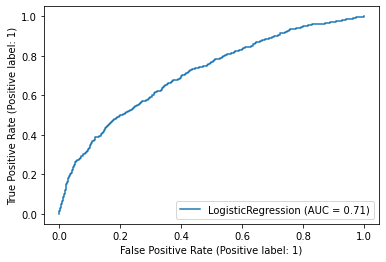

In [24]:
### threshold = 0.6

### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state = 101)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")
y_train_probabillity = log_reg.predict_proba(X_train)[:,1]
y_train_pred = np.where(y_train_probabillity >= 0.6, 1, 0)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 63.33
ROC-AUC Score: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       343
           1       0.76      0.42      0.54       366

    accuracy                           0.63       709
   macro avg       0.67      0.64      0.62       709
weighted avg       0.68      0.63      0.62       709


Confusion Matrix:
[[295  48]
 [212 154]]

 ROC-AUC Curve for the validation set


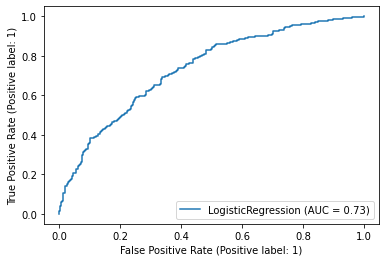

In [25]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_probabillity = log_reg.predict_proba(X_validate)[:,1]
y_validate_pred = np.where(y_validate_probabillity >= 0.6, 1, 0)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 63.66
ROC-AUC Score: 0.725

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.84      0.69       341
           1       0.75      0.45      0.56       369

    accuracy                           0.64       710
   macro avg       0.67      0.64      0.63       710
weighted avg       0.67      0.64      0.62       710


Confusion Matrix:
[[286  55]
 [203 166]]

 ROC-AUC Curve for the testing set


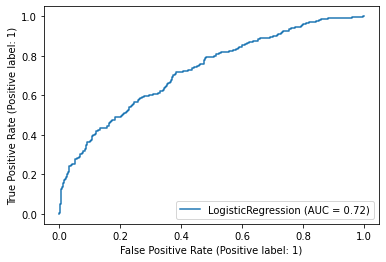

In [26]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_probabillity = log_reg.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_probabillity >= 0.6, 1, 0)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()

In [27]:
print("Cumulative Gains Curve - Logistic Regression")
skplt.metrics.plot_cumulative_gain(y_test, log_reg.predict_proba(X_test))
plt.show()

Cumulative Gains Curve - Logistic Regression


NameError: name 'skplt' is not defined

In [ ]:
### Since the total number of data points in the test set are 710, it means each decile can have 
### about 710/10 = 71 data points. Since y_test has 350 positive class points, we get 71/369 = 19.2 % maximum lift.
### From the graph, we get around 18% of the lift from our model. Hence our model is performing close to maximum performance.

y_test.value_counts()

In [34]:
### XGBoost Model to compare the results with the Logistic Regression model

xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

# initializing the gridsearch and finding optimum set of hyperparameters. Error metric used is roc_auc score.
# Training the gridsearch and finding the best model.
xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_


Training
------------------------------------------------------------
Accuracy % age: 81.85
ROC-AUC Score: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1089
           1       0.83      0.80      0.81      1038

    accuracy                           0.82      2127
   macro avg       0.82      0.82      0.82      2127
weighted avg       0.82      0.82      0.82      2127


Confusion Matrix:
[[915 174]
 [212 826]]

 ROC-AUC Curve for the training set


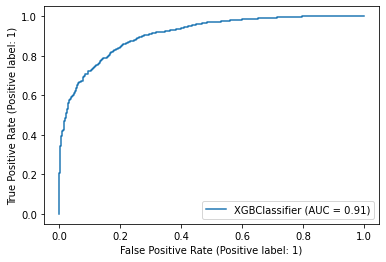

In [35]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_best_model.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

print("\nTraining\n------------------------------------------------------------")
y_train_pred = xgb_best_model.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(xgb_best_model, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 68.41
ROC-AUC Score: 0.765

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       343
           1       0.69      0.70      0.69       366

    accuracy                           0.68       709
   macro avg       0.68      0.68      0.68       709
weighted avg       0.68      0.68      0.68       709


Confusion Matrix:
[[230 113]
 [111 255]]

 ROC-AUC Curve for the validation set


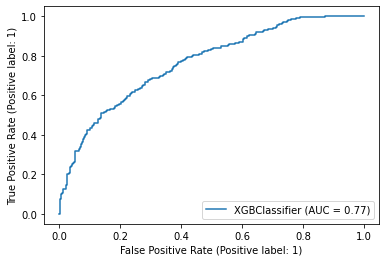

In [36]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_validate_pred = xgb_best_model.predict(X_validate)
error_metrics(y_validate, y_validate_pred, X_validate)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(xgb_best_model, X_validate, y_validate)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 68.17
ROC-AUC Score: 0.767

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       341
           1       0.70      0.68      0.69       369

    accuracy                           0.68       710
   macro avg       0.68      0.68      0.68       710
weighted avg       0.68      0.68      0.68       710


Confusion Matrix:
[[233 108]
 [118 251]]

 ROC-AUC Curve for the testing set


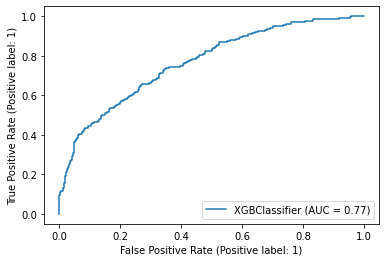

In [37]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = xgb_best_model.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(xgb_best_model, X_test, y_test)
plt.show()

In [ ]:
print("Cumulative Gains Curve - XGBoost")
skplt.metrics.plot_cumulative_gain(y_test, xgb_best_model.predict_proba(X_test))
plt.show()

In [28]:
### Since the total number of data points in the test set are 710, it means each decile can have 
### about 710/10 = 71 data points. Since y_test has 340 positive class points, we get 71/369 = 19.2 % maximum lift.
### From the graph, we get above 19% of lift from our model. Hence our model is very near to the maximum 
### possible performance.

y_test.value_counts()

1    369
0    341
Name: campaign_response, dtype: int64

In [38]:
# Drivers of Response

In [39]:
import statsmodels.api as sm

In [40]:
logit = sm.Logit(y_train,sm.add_constant(X_train)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.589770
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      campaign_response   No. Observations:                 2127
Model:                          Logit   Df Residuals:                     2084
Method:                           MLE   Df Model:                           42
Date:                Tue, 14 Jun 2022   Pseudo R-squ.:                  0.1488
Time:                        14:33:55   Log-Likelihood:                -1254.4
converged:                       True   LL-Null:                       -1473.7
Covariance Type:            nonrobust   LLR p-value:                 1.763e-67
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.9012      0.590      1.527      0.127      -0.256       2.058
app_usage                          -0.4110      0.099     -4.140      0.000      -0.606      -0.216
tenure                             -0.0090      0.003     -3.426      0.001      -0.014      -0.004
number_complaints                   0.0285      0.004      7.354      0.000       0.021       0.036
direct_emails                      -0.0075      0.001     -8.995      0.000      -0.009      -0.006
direct_mails                       -0.0067      0.003     -2.360      0.018      -0.012      -0.001
privelege_card                     -0.3856      0.110     -3.504      0.000      -0.601      -0.170
in_store_wine_transactions          0.0017      0.001      1.709      0.087      -0.000       0.004
in_store_beer_transactions          0.0012      0.004      0.266      0.791      -0.007       0.010
in_store_spirits_transactions      -0.0023      0.001     -2.287      0.022      -0.004      -0.000
delivery_spirits_transactions       0.0049      0.008      0.588      0.556      -0.011       0.021
delivery_wine_transactions          0.0004      0.000      3.007      0.003       0.000       0.001
delivery_beer_transactions       5.721e-06      0.000      0.052      0.959      -0.000       0.000
occupation_Retired                 -0.0728      0.270     -0.270      0.787      -0.601       0.456
occupation_Student                  0.2217      0.231      0.961      0.336      -0.230       0.674
occupation_Unemployed               0.6290      0.322      1.951      0.051      -0.003       1.261
occupation_Working Professional     0.0981      0.224      0.437      0.662      -0.342       0.538
gender_M                            0.0487      0.097      0.500      0.617      -0.142       0.240
region_Sub-Urban                    0.3766      0.123      3.073      0.002       0.136       0.617
region_Urban                        0.5330      0.121      4.412      0.000       0.296       0.770
age_between_30_50                  -0.0288      0.117     -0.246      0.806      -0.259       0.201
age_above_50                       -0.1782      0.132     -1.352      0.177      -0.437       0.080
state_12                           -0.5324      0.191     -2.781      0.005      -0.908      -0.157
state_17                           -0.6597      0.227     -2.909      0.004      -1.104      -0.215
state_25                           -0.8396      0.234     -3.593      0.000      -1.298      -0.382
state_33                           -0.6086      0.244     -2.498      0.013      -1.086      -0.131
state_34                           -0.5592      0.244     -2.295      0.022      -1.037      -0.082
state_36                           -0.1644      0.209     -0.787      0.431      -0.574       0.245
state_37                           -0.1111      0.225     -0.494      0.621      -0.552       0.329
state_45                           -0.173

In [41]:
# Backward Elimination
# Manual selection  of features
# Can be used to build a better model

# RFE or SFS effective methods of feature selection

In [48]:
pval = logit.pvalues.round(3)
impt_feat = pval[pval<0.05].index
logit = sm.Logit(y_train,sm.add_constant(X_train[impt_feat])).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.594422
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      campaign_response   No. Observations:                 2127
Model:                          Logit   Df Residuals:                     2105
Method:                           MLE   Df Model:                           21
Date:                Tue, 14 Jun 2022   Pseudo R-squ.:                  0.1421
Time:                        14:36:59   Log-Likelihood:                -1264.3
converged:                       True   LL-Null:                       -1473.7
Covariance Type:            nonrobust   LLR p-value:                 1.210e-75
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.8697      0.302      2.883      0.004       0.279       1.461
app_usage                        -0.4328      0.098     -4.406      0.000      -0.625      -0.240
tenure                           -0.0092      0.003     -3.518      0.000      -0.014      -0.004
number_complaints                 0.0275      0.004      7.277      0.000       0.020       0.035
direct_emails                    -0.0070      0.001     -8.978      0.000      -0.009      -0.006
direct_mails                     -0.0060      0.003     -2.132      0.033      -0.011      -0.000
privelege_card                   -0.4120      0.108     -3.798      0.000      -0.625      -0.199
in_store_spirits_transactions    -0.0021      0.001     -2.308      0.021      -0.004      -0.000
delivery_wine_transactions        0.0004      0.000      3.233      0.001       0.000       0.001
region_Sub-Urban                  0.3721      0.122      3.060      0.002       0.134       0.610
region_Urban                      0.5234      0.120      4.374      0.000       0.289       0.758
state_12                         -0.3786      0.164     -2.304      0.021      -0.701      -0.056
state_17                         -0.5055      0.204     -2.477      0.013      -0.905      -0.105
state_25                         -0.6853      0.211     -3.248      0.001      -1.099      -0.272
state_33                         -0.4847      0.222     -2.184      0.029      -0.920      -0.050
state_34                         -0.4104      0.222     -1.846      0.065      -0.846       0.025
segment_2                        -0.8749      0.142     -6.158      0.000      -1.153      -0.596
segment_3                        -0.3624      0.130     -2.797      0.005      -0.616      -0.108
segment_4                        -0.3126      0.128     -2.438      0.015      -0.564      -0.061
in_store_wine_price               0.0033      0.000      7.376      0.000       0.002       0.004
delivery_wine_price               0.0006      8e-05      7.175      0.000       0.000       0.001
delivery_beer_price               0.0004      0.000      3.376      0.001       0.000       0.001
=================================================================================================
"""

In [ ]:
# validate the model performance 

In [34]:
### Drivers of response

xgb_imp_df = pd.DataFrame()
xgb_imp_df['cols'] = X_train.columns
xgb_imp_df['importance'] = xgb_best_model.feature_importances_
xgb_imp_df = xgb_imp_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
xgb_imp_df

,cols,importance
0,direct_emails,0.054436
1,in_store_wine_price,0.044596
2,segment_2,0.043104
3,number_complaints,0.040525
4,delivery_wine_price,0.037070
5,direct_mails,0.031525
6,occupation_Retired,0.031348
7,app_usage,0.030408
8,occupation_Unemployed,0.029239
9,state_12,0.029212


In [49]:
### Relationship between variables
df_summary.head()

,app_usage,age,gender,region,tenure,state,campaign_response,number_complaints,direct_emails,direct_mails,...,in_store_spirits_dollar_sales,delivery_spirits_dollar_sales,delivery_wine_dollar_sales,delivery_beer_dollar_sales,in_store_wine_eq_volume,in_store_beer_eq_volume,in_store_spirits_eq_volume,delivery_spirits_eq_volume,delivery_wine_eq_volume,delivery_beer_eq_volume
0,0,between_30_50,F,Urban,95,53,0,25,101,27,...,2685,3120,5925,1454,10.0,30.1,10.0,63.6,41,542
1,1,above_50,F,Urban,93,36,0,0,84,0,...,25,400,5925,47092,10.0,30.7,95.7,52.6,259,41
2,0,between_30_50,M,Rural,108,48,0,25,141,53,...,925,2320,55233,72134,35.5,28.3,19.4,50.8,41,199
3,0,above_50,M,Rural,97,36,0,19,157,36,...,25,3760,5925,58872,29.0,31.1,85.6,55.0,3284,383
4,0,between_30_50,F,Urban,95,17,0,0,76,0,...,25,3280,98577,25090,54.5,38.5,10.0,60.2,104,1654


In [36]:
### Impact of app usage.

app_usage_1 = df_summary.query('app_usage == 0').groupby(['app_usage', 'campaign_response'])['region'].count().reset_index(name="data_count")
app_usage_1['class_percentage'] = np.round(app_usage_1.eval(f"data_count/{app_usage_1.data_count.sum()}"), 2)

app_usage_2 = df_summary.query('app_usage == 1').groupby(['app_usage', 'campaign_response'])['region'].count().reset_index(name="data_count")
app_usage_2['class_percentage'] = np.round(app_usage_2.eval(f"data_count/{app_usage_2.data_count.sum()}"), 2)

app_usage_df = app_usage_1.append(app_usage_2)
app_usage_df

### From the data below it is clear that usage of app leads to 6 % reduction in responses.

,app_usage,campaign_response,data_count,class_percentage
0,0,0,4129,0.75
1,0,1,1380,0.25
0,1,0,3651,0.81
1,1,1,840,0.19


In [ ]:
# 25% people who is not using the app have responded 
# 19% people who is using the app have responded

In [52]:
import scipy.stats as stats

In [56]:
cont_tab = pd.crosstab(df['app_usage'],df['campaign_response'])
stats.chi2_contingency(cont_tab)

(22.047934733173722,
 2.65925651920907e-06,
 1,
 array([[1028.5, 1028.5],
        [ 744.5,  744.5]]))

In [ ]:
# pval = 0
# pval < sig lvl
# Ha is selected
# The two cat features are related

In [ ]:
# Based on logit result, pval of app is 0. Which means that is signifcant features.
# comparing to the no app users,The log odds of probability of campaign response app users
# decreases by 0.43 

In [37]:
### Impact of Direct Mails

df_summary.groupby('campaign_response')['direct_mails'].mean().reset_index(name="mean_average_direct_mails")

### From the data below it is clear for campaign response, direct mails are on average 14.8% lower compared to that
### in case of no response.

,campaign_response,mean_average_direct_mails
0,0,16.895501
1,1,14.237387


In [38]:
### Impact of Direct Emails

df_summary.groupby('campaign_response')['direct_emails'].mean().reset_index(name="mean_average_direct_emails")

### From the data below it is clear for campaign response being 1, direct emails are on average 2/3 compared to that
### in case of response being 0. This is expected since emailing stops the moment a client responds.

,campaign_response,mean_average_direct_emails
0,0,62.921722
1,1,39.176126


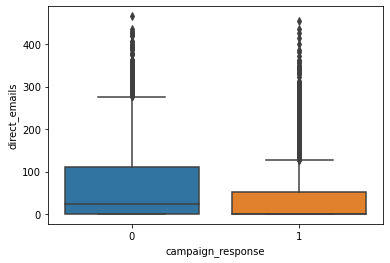

In [58]:
sns.boxplot(x='campaign_response',y='direct_emails',data=df_summary)
plt.show()

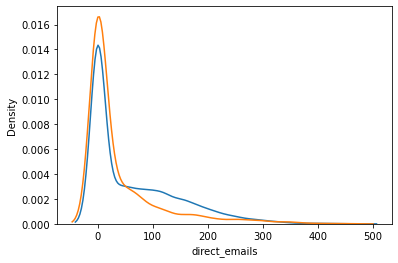

In [61]:
sns.kdeplot(df_summary[df_summary['campaign_response']==0]['direct_emails'])
sns.kdeplot(df_summary[df_summary['campaign_response']==1]['direct_emails'])
plt.show()

In [62]:
# Ho : avg is same
# Ha : avg is different

In [64]:
stats.ttest_ind(df_summary[df_summary['campaign_response']==0]['direct_emails'],
               df_summary[df_summary['campaign_response']==1]['direct_emails'])

Ttest_indResult(statistic=12.524016057701324, pvalue=1.0220922096218878e-35)

In [65]:
# pval<0.05
# The two sample are different w.r.t to campaign response

In [66]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      campaign_response   No. Observations:                 2127
Model:                          Logit   Df Residuals:                     2105
Method:                           MLE   Df Model:                           21
Date:                Tue, 14 Jun 2022   Pseudo R-squ.:                  0.1421
Time:                        15:09:24   Log-Likelihood:                -1264.3
converged:                       True   LL-Null:                       -1473.7
Covariance Type:            nonrobust   LLR p-value:                 1.210e-75
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.8697      0.302      2.883      0.004       0.279       1.461
app_usage                        -0.4328      0.098     -4.406      0.000      -0.625      -0.240
tenure                           -0.0092      0.003     -3.518      0.000      -0.014      -0.004
number_complaints                 0.0275      0.004      7.277      0.000       0.020       0.035
direct_emails                    -0.0070      0.001     -8.978      0.000      -0.009      -0.006
direct_mails                     -0.0060      0.003     -2.132      0.033      -0.011      -0.000
privelege_card                   -0.4120      0.108     -3.798      0.000      -0.625      -0.199
in_store_spirits_transactions    -0.0021      0.001     -2.308      0.021      -0.004      -0.000
delivery_wine_transactions        0.0004      0.000      3.233      0.001       0.000       0.001
region_Sub-Urban                  0.3721      0.122      3.060      0.002       0.134       0.610
region_Urban                      0.5234      0.120      4.374      0.000       0.289       0.758
state_12                         -0.3786      0.164     -2.304      0.021      -0.701      -0.056
state_17                         -0.5055      0.204     -2.477      0.013      -0.905      -0.105
state_25                         -0.6853      0.211     -3.248      0.001      -1.099      -0.272
state_33                         -0.4847      0.222     -2.184      0.029      -0.920      -0.050
state_34                         -0.4104      0.222     -1.846      0.065      -0.846       0.025
segment_2                        -0.8749      0.142     -6.158      0.000      -1.153      -0.596
segment_3                        -0.3624      0.130     -2.797      0.005      -0.616      -0.108
segment_4                        -0.3126      0.128     -2.438      0.015      -0.564      -0.061
in_store_wine_price               0.0033      0.000      7.376      0.000       0.002       0.004
delivery_wine_price               0.0006      8e-05      7.175      0.000       0.000       0.001
delivery_beer_price               0.0004      0.000      3.376      0.001       0.000       0.001
=================================================================================================
"""

In [67]:
# pval = 0. Feature is important
# When direact email increases by 1 units, the log odds of probability of campaign response decrease
# by 0.007


In [39]:
### Response pattern among urban young male population

df_summary['urban_young_male_tag'] = np.where((df_summary['age'] == 'below_30') &
                                              (df_summary['gender'] == 'M') &
                                              (df_summary['region'] == 'Urban'), 1, 0)

df_summary_0 = df_summary.query('urban_young_male_tag == 0').groupby(['urban_young_male_tag', 'campaign_response'])['region'].count().reset_index(name="data_count")
df_summary_0['class_percentage'] = np.round(df_summary_0.eval(f"data_count/{df_summary_0.data_count.sum()}"), 2)

df_summary_1 = df_summary.query('urban_young_male_tag == 1').groupby(['urban_young_male_tag', 'campaign_response'])['region'].count().reset_index(name="data_count")
df_summary_1['class_percentage'] = np.round(df_summary_1.eval(f"data_count/{df_summary_1.data_count.sum()}"), 2)

df_case_1 = df_summary_0.append(df_summary_1)
df_case_1

### From the data below it is clear that in the urban young male population group, the response rate is 9 % more than others.

,urban_young_male_tag,campaign_response,data_count,class_percentage
0,0,0,7488,0.78
1,0,1,2090,0.22
0,1,0,292,0.69
1,1,1,130,0.31


In [40]:
### Impact of count, sales and volume on response.

sales_cols = [col for col in df_summary.columns if '_sales' in col]
volume_cols = [col for col in df_summary.columns if '_volume' in col]

df_summary['sales_sum'] = df_summary[sales_cols].sum(axis=1)
df_summary['volume_sum'] = df_summary[volume_cols].sum(axis=1)

df_case_2 = df_summary.groupby('campaign_response')['sales_sum'].count().reset_index(name="count")

df_case_2 = df_case_2.merge(df_summary.groupby('campaign_response')['sales_sum'].sum().reset_index(name="total_sales"),
                           on="campaign_response", how="left")
df_case_2['mean_sales'] = np.round(df_case_2.eval('total_sales/count')).astype(int)

df_case_2 = df_case_2.merge(df_summary.groupby('campaign_response')['volume_sum'].sum().reset_index(name="total_volume"),
                           on="campaign_response", how="left")
df_case_2['mean_volume'] = np.round(df_case_2.eval('total_volume/count')).astype(int)
df_case_2.head()

### From the below data we can see that for response, mean sales is around 49% higher,
### whereas incase of volume, it is 19.2% higher for response.

,campaign_response,count,total_sales,mean_sales,total_volume,mean_volume
0,0,7780,522855410,67205,10184895.6,1309
1,1,2220,222768990,100346,3450817.7,1554


In [41]:
### Segment wise drivers of response

x = df_summary.copy()
x = x[['app_usage', 'age', 'gender', 'region', 'tenure', 'state', 'campaign_response', 'number_complaints', 'direct_emails',
       'direct_mails', 'segment', 'occupation', 'privelege_card', 'sales_sum', 'volume_sum']]
x.head()

,app_usage,age,gender,region,tenure,state,campaign_response,number_complaints,direct_emails,direct_mails,segment,occupation,privelege_card,sales_sum,volume_sum
0,0,between_30_50,F,Urban,95,53,0,25,101,27,3,Working Professional,0,15208,696.7
1,1,above_50,F,Urban,93,36,0,0,84,0,0,Working Professional,0,54245,489.0
2,0,between_30_50,M,Rural,108,48,0,25,141,53,3,Working Professional,0,131625,374.0
3,0,above_50,M,Rural,97,36,0,19,157,36,3,Student,1,69511,3867.7
4,0,between_30_50,F,Urban,95,17,0,0,76,0,2,Working Professional,0,137636,1921.2


In [42]:
### Analysing age

age_y = x.groupby(['segment', 'campaign_response', 'age'])['region'].count().reset_index(name="number_of_leads")
age_y_1 = x.groupby(['segment', 'campaign_response'])['region'].count().reset_index(name="total_number_of_leads")

age_y_2 = age_y.merge(age_y_1, on = ['segment', 'campaign_response'], how = "left")
age_y_2['percentage_age'] = np.round(age_y_2.eval('number_of_leads*100/total_number_of_leads'), 2)
age_y_2 = age_y_2.drop(columns=['number_of_leads', 'total_number_of_leads'])

keep_cols = ['segment', 'age', 'percentage_age']

age_segment_df = pd.concat([age_y_2.query('campaign_response == 0')[keep_cols].reset_index(drop=True), age_y_2.query('campaign_response == 1')[keep_cols].reset_index(drop=True)], axis = 1)
age_segment_df = age_segment_df.iloc[:,[0, 1, 2, 5]]
age_segment_df.columns = ['segment', 'age', 'percentage_age_resp_0', 'percentage_age_resp_1']
age_segment_df['response_tendency'] = age_segment_df.eval('percentage_age_resp_1 - percentage_age_resp_0')
age_segment_df

### From the below data, we can see that age is a constant driver of response. Across all the segments, 
### people in the campaign with less than 50 ages showed greater tendency to respond, whereas those above 50
### showed less tendency to respond. The difference between response peaks for segment 3.

,segment,age,percentage_age_resp_0,percentage_age_resp_1,response_tendency
0,0,below_30,25.10,28.41,3.31
1,0,between_30_50,43.49,44.72,1.23
2,0,above_50,31.41,26.87,-4.54
3,1,below_30,26.66,28.75,2.09
4,1,between_30_50,42.66,43.92,1.26
5,1,above_50,30.68,27.34,-3.34
6,2,below_30,26.17,27.24,1.07
7,2,between_30_50,41.84,45.15,3.31
8,2,above_50,31.98,27.61,-4.37
9,3,below_30,27.66,30.11,2.45


In [43]:
### Gender

gender_y = x.groupby(['segment', 'campaign_response', 'gender'])['region'].count().reset_index(name="number_of_leads")
gender_y_1 = x.groupby(['segment', 'campaign_response'])['region'].count().reset_index(name="total_number_of_leads")

gender_y_2 = gender_y.merge(gender_y_1, on = ['segment', 'campaign_response'], how = "left")
gender_y_2['percentage_gender'] = np.round(gender_y_2.eval('number_of_leads*100/total_number_of_leads'), 2)
gender_y_2 = gender_y_2.drop(columns=['number_of_leads', 'total_number_of_leads'])

keep_cols = ['segment', 'gender', 'percentage_gender']

gender_segment_df = pd.concat([gender_y_2.query('campaign_response == 0')[keep_cols].reset_index(drop=True), gender_y_2.query('campaign_response == 1')[keep_cols].reset_index(drop=True)], axis = 1)
gender_segment_df = gender_segment_df.iloc[:,[0, 1, 2, 5]]
gender_segment_df.columns = ['segment', 'gender', 'percentage_gender_resp_0', 'percentage_gender_resp_1']
gender_segment_df['response_tendency'] = gender_segment_df.eval('percentage_gender_resp_1 - percentage_gender_resp_0')
gender_segment_df

### From the below data, gender shows a more powerful trend for segments 2 and 3, with difference of response peaking
### at ~3.6% for segment 2. However, across all segments, female participants show less tendency to respond.

,segment,gender,percentage_gender_resp_0,percentage_gender_resp_1,response_tendency
0,0,F,49.54,48.56,-0.98
1,0,M,50.46,51.44,0.98
2,1,F,52.67,51.68,-0.99
3,1,M,47.33,48.32,0.99
4,2,F,50.59,47.01,-3.58
5,2,M,49.41,52.99,3.58
6,3,F,50.94,48.74,-2.20
7,3,M,49.06,51.26,2.20
8,4,F,50.47,52.21,1.74
9,4,M,49.53,47.79,-1.74


In [44]:
### Region

region_y = x.groupby(['segment', 'campaign_response', 'region'])['region'].count().reset_index(name="number_of_leads")
region_y_1 = x.groupby(['segment', 'campaign_response'])['region'].count().reset_index(name="total_number_of_leads")

region_y_2 = region_y.merge(region_y_1, on = ['segment', 'campaign_response'], how = "left")
region_y_2['percentage_region'] = np.round(region_y_2.eval('number_of_leads*100/total_number_of_leads'), 2)
region_y_2 = region_y_2.drop(columns=['number_of_leads', 'total_number_of_leads'])

keep_cols = ['segment', 'region', 'percentage_region']

region_segment_df = pd.concat([region_y_2.query('campaign_response == 0')[keep_cols].reset_index(drop=True), region_y_2.query('campaign_response == 1')[keep_cols].reset_index(drop=True)], axis = 1)
region_segment_df = region_segment_df.iloc[:,[0, 1, 2, 5]]
region_segment_df.columns = ['segment', 'region', 'percentage_region_resp_0', 'percentage_region_resp_1']
region_segment_df['response_tendency'] = region_segment_df.eval('percentage_region_resp_1 - percentage_region_resp_0')
region_segment_df

### From the below data, region shows an uneven trend for different segments, with difference of response being
### very different across segments 0 and 1, but fairly constant in the others.
### Rural areas show signicantly less tendency to respond, and opposite jump in responses for urban areas for segments 0 & 1.
### Other segments show much weaker differences between the three.

,segment,region,percentage_region_resp_0,percentage_region_resp_1,response_tendency
0,0,Rural,35.13,25.53,-9.60
1,0,Sub-Urban,34.53,33.40,-1.13
2,0,Urban,30.35,41.07,10.72
3,1,Rural,38.20,24.51,-13.69
4,1,Sub-Urban,32.51,34.39,1.88
5,1,Urban,29.29,41.09,11.80
6,2,Rural,34.33,30.22,-4.11
7,2,Sub-Urban,31.98,35.07,3.09
8,2,Urban,33.69,34.70,1.01
9,3,Rural,33.17,28.74,-4.43


In [45]:
### Tenure

tenure_df = x.groupby(['segment', 'campaign_response'])['tenure'].mean().reset_index()
tenure_df = tenure_df.pivot(index='segment', columns='campaign_response')['tenure'].reset_index()
tenure_df.columns = ['segment', 'mean_tenure_resp_0', 'mean_tenure_resp_1']
tenure_df['response_tendency'] = tenure_df.eval('mean_tenure_resp_1 - mean_tenure_resp_0')
tenure_df

### For tenure, segments show uneven trends, with segment 1 and 3 showing greater mean tenure gaps compared to others.

,segment,mean_tenure_resp_0,mean_tenure_resp_1,response_tendency
0,0,100.568393,98.598848,-1.969545
1,1,101.713660,97.525573,-4.188086
2,2,99.751174,98.697761,-1.053413
3,3,101.993116,97.319540,-4.673576
4,4,100.202121,97.125874,-3.076247


In [46]:
### direct_emails

direct_email_df = x.groupby(['segment', 'campaign_response'])['direct_emails'].mean().reset_index()
direct_email_df = direct_email_df.pivot(index='segment', columns='campaign_response')['direct_emails'].reset_index()
direct_email_df.columns = ['segment', 'mean_direct_emails_resp_0', 'mean_direct_emails_resp_1']
direct_email_df['response_tendency'] = direct_email_df.eval('mean_direct_emails_resp_1 - mean_direct_emails_resp_0')
direct_email_df

### For direct_emails, segments again show uneven trends, with segment 1 and 4 showing less mean direct email counts
### compared to others. The mean email counts peak for segment 2, and are lowest for segment 1.

,segment,mean_direct_emails_resp_0,mean_direct_emails_resp_1,response_tendency
0,0,64.628818,40.095969,-24.532849
1,1,65.635500,45.615520,-20.019980
2,2,62.346831,29.063433,-33.283398
3,3,63.985607,37.225287,-26.760320
4,4,58.550842,37.843823,-20.707019
